In [1]:
import pyam
import pandas as pd
import os
import dotenv
import sys

sys.path.append('../scripts')
from utils import Validation, Filters

from pathlib import Path
%load_ext autoreload
%autoreload 2

c:\Users\gidden\Miniconda3\envs\pyam\Lib\site-packages\xarray\backends\cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


<IPython.core.display.Javascript object>

In [2]:
fulldf = pd.read_csv(os.environ['AR6_RAW'])

In [3]:
voi = [
    'Carbon Sequestration|CCS',
    'Primary Energy|Fossil|w/ CCS',
    'Carbon Sequestration|CCS|Fossil',
    'Primary Energy|Fossil',
    'Primary Energy|Biomass',
    'Primary Energy|Non-Biomass Renewables',
]

pddf = fulldf[fulldf.Variable.isin(voi)]

df = pyam.IamDataFrame(pddf)
df.load_meta(os.environ['AR6_META'])

c:\users\gidden\onedrive - iiasa\work\iiasa\pyam\pyam\utils.py:318: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(dropna=True)
pyam.core - WARNING: Ignoring meta indicators for the following scenarios:
         model                       scenario
0  AIM/CGE 2.2   ADVANCE_WP2_IND-450-FullTech
1  AIM/CGE 2.2  ADVANCE_WP2_IND-Base-FullTech
2  AIM/CGE 2.2   ADVANCE_WP2_TRA-450-FullTech
3  AIM/CGE 2.2  ADVANCE_WP2_TRA-Base-FullTech
4  AIM/CGE 2.2  ADVANCE_WP2_TRA-Ctax-FullTech
...
         model                       scenario
0  AIM/CGE 2.2   ADVANCE_WP2_IND-450-FullTech
1  AIM/CGE 2.2  ADVANCE_WP2_IND-Base-FullTech
2  AIM/CGE 2.2   ADVANCE_WP2_TRA-450-FullTech
3  AIM/CGE 2.2  ADVANCE_WP2_TRA-Base-FullTech
4  AIM/CGE 2.2  ADVANCE_WP2_TRA-Ctax-FullTech
...


In [4]:
def make_cumulative_df(df, vold, vnew, offset=True):
    data = df.filter(variable=vold).interpolate(range(2020, 2101))
    if offset:
        data = data.offset(year=2020)
    ret = pyam.IamDataFrame(
        data
        .filter(year=range(2020, 2101))
        .rename(variable={vold: vnew})
        .timeseries()
        .cumsum(axis=1)
    )
    ret.set_meta(data.meta)
    return ret

In [5]:
cumulative_vars = [
    dict(vold='Carbon Sequestration|CCS', vnew='Cumulative CCS', offset=True),
    dict(vold='Primary Energy|Fossil', vnew='Cumulative Fossil PE', offset=False),
    dict(vold='Primary Energy|Biomass', vnew='Cumulative Biomass PE', offset=False),
    dict(vold='Primary Energy|Non-Biomass Renewables', vnew='Cumulative Renewables PE', offset=False),
]
cum_data = pyam.concat([
    make_cumulative_df(df, **kwargs) for kwargs in cumulative_vars
    ])
pdf = pyam.concat([df, cum_data])

Text(0.5, 1.0, 'Cumulative Carbon Stored via CCS')

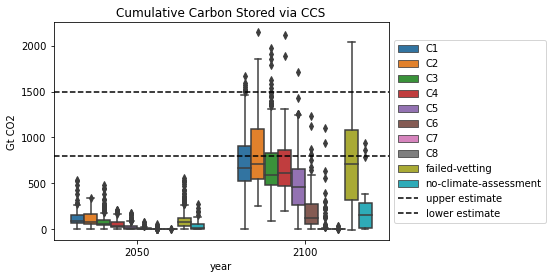

In [6]:
ax = (
    pdf
    .filter(variable='Cumulative CCS', year=[2050, 2100], region='World')
    .convert_unit('Mt CO2/yr', 'Gt CO2', factor=1e-3)
    .plot.box(x="year", by="Category", legend=True)
)
ax.axhline(1500, c='k', ls='--', label='upper estimate')
ax.axhline(800, c='k', ls='--', label='lower estimate')
ax.legend(**pyam.plotting.OUTSIDE_LEGEND['right'])
ax.set_title('Cumulative Carbon Stored via CCS')

# Apply labels to scenarios

In [7]:
validator = Validation(
    db=pdf,
    definitions_path='../definitions/filters.yml'
)

validator.create_validation_columns(
    generate_summary=True
)

validator.summary

INFO:utils:Creating validation column for cstorage_low using defined proxy Cumulative CCS
INFO:utils:Creating validation column for cstorage_mid using defined proxy Cumulative CCS
INFO:utils:Creating validation column for cstorage_high using defined proxy Cumulative CCS
INFO:utils:Creating validation column for cstorage_max using defined proxy Cumulative CCS


validation_cstorage_low  validation_cstorage_mid  validation_cstorage_high  validation_cstorage_max
True                     True                     True                      True                       1721
False                    False                    False                     False                       182
Name: count, dtype: int64

In [8]:
filters = Filters(
    db=validator.db.filter(year=range(2020, 2105,5)),
    definitions_path='../definitions/filters.yml'
)

filters.apply_filters()
filters.apply_categories()

INFO:utils:Preparing filter sets for cstorage_low
pyam.validation - INFO: 448 of 245423 data points do not satisfy the criteria
INFO:pyam.validation:448 of 245423 data points do not satisfy the criteria
INFO:utils:Preparing filter sets for cstorage_mid
pyam.validation - INFO: 1428 of 245423 data points do not satisfy the criteria
INFO:pyam.validation:1428 of 245423 data points do not satisfy the criteria
INFO:utils:Preparing filter sets for cstorage_high
pyam.validation - INFO: 1379 of 245423 data points do not satisfy the criteria
INFO:pyam.validation:1379 of 245423 data points do not satisfy the criteria
INFO:utils:Preparing filter sets for cstorage_max
pyam.validation - INFO: 1542 of 245423 data points do not satisfy the criteria
INFO:pyam.validation:1542 of 245423 data points do not satisfy the criteria
INFO:utils:Preparing categorization for cstorage_low
pyam.validation - INFO: 448 of 245423 data points do not satisfy the criteria
INFO:pyam.validation:448 of 245423 data points do 

<Axes: xlabel='Cumulative CCS', ylabel='Cumulative Fossil PE'>

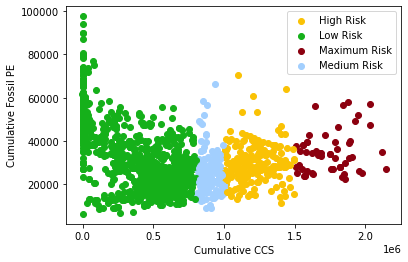

In [9]:
filters.db.filter(year=2100).plot.scatter('Cumulative CCS', 'Cumulative Fossil PE', color='Carbon Storage')

In [10]:
filters.db.set_meta_from_data('Cumulative CCS in 2100', **{'variable': 'Cumulative CCS', 'region': 'World', 'year': 2100})
filters.db.set_meta_from_data('Cumulative Fossil PE in 2100', **{'variable': 'Cumulative Fossil PE', 'region': 'World', 'year': 2100})


<Axes: xlabel='Cumulative Fossil PE in 2100', ylabel='Median peak warming (MAGICCv7.5.3)'>

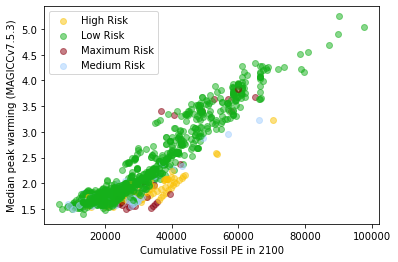

In [11]:
filters.db.filter(Category='C*').plot.scatter(
    'Cumulative Fossil PE in 2100', 'Median peak warming (MAGICCv7.5.3)', 
    color='Carbon Storage', alpha=0.5,
    )

<Axes: xlabel='Cumulative Fossil PE in 2100', ylabel='Median peak warming (MAGICCv7.5.3)'>

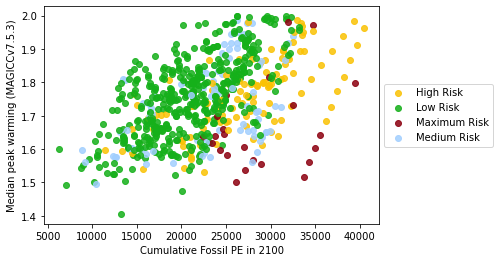

In [12]:
filters.db.filter(Category=['C1', 'C2', 'C3', 'C4']).plot.scatter(
    'Cumulative Fossil PE in 2100', 'Median peak warming (MAGICCv7.5.3)', 
    color='Carbon Storage', alpha=0.85,
    legend={'loc': 'outside right'}
    )